In [53]:
import os

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

Data Description:

* userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40)
* sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
* retention_1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

In [54]:
df = pd.read_csv("../Data/cookie_cats.csv")
display(df.head())
display(df.describe())
print(df.shape)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


(90189, 5)


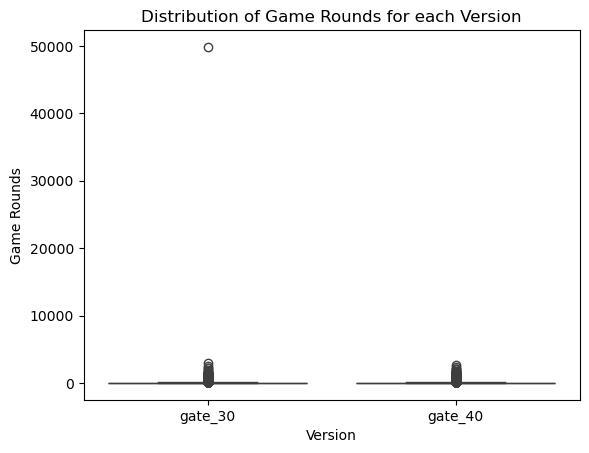

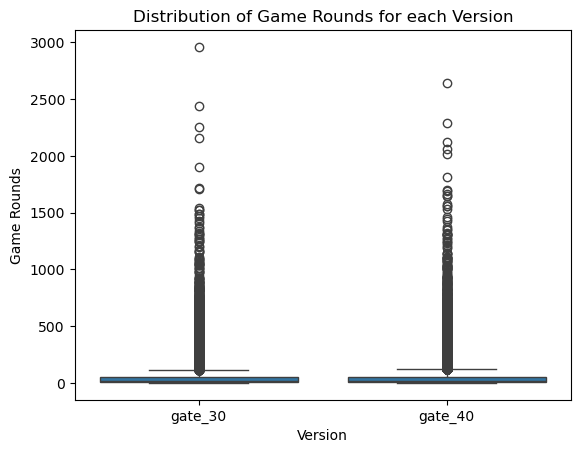

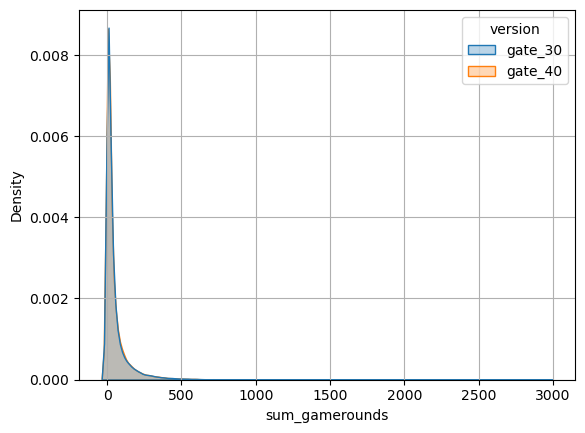

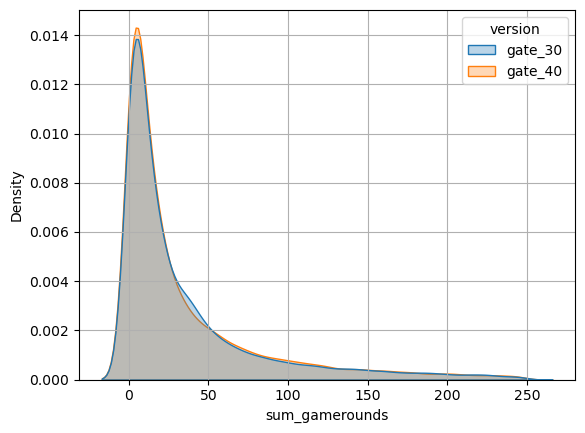

In [55]:
def create_dist_plots():
    sns.boxplot(data=df, x="version", y="sum_gamerounds")
    plt.title("Distribution of Game Rounds for each Version")
    plt.xlabel("Version")
    plt.ylabel("Game Rounds")
    plt.show()
    
create_dist_plots() # one major outlier
df = df[df["sum_gamerounds"] < 30000]
create_dist_plots()
sns.kdeplot(data=df, x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()
sns.kdeplot(data=df[df["sum_gamerounds"] < 250], x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()

In [56]:
df[df["sum_gamerounds"]==0].count()

userid            3994
version           3994
sum_gamerounds    3994
retention_1       3994
retention_7       3994
dtype: int64